# Shot By Shot Logestic Regression

In [73]:
# Import Relevant Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Reading in data

In [74]:
shot_data = pd.read_csv('shot_dataset.csv')
shot_data = shot_data.drop(columns = ['Unnamed: 0'])

In [75]:
print(shot_data)

         SHOT_MADE  SHOT_TYPE  LOC_X  LOC_Y  SHOT_DISTANCE  MINS_LEFT  \
0                1          0   23.4  12.95             24         11   
1                1          1   -1.3   5.25              1         10   
2                0          1   -2.2   6.95              2          8   
3                1          0   19.7  20.55             24          7   
4                1          0   -8.3  29.85             25          7   
...            ...        ...    ...    ...            ...        ...   
2947516          1          1   -0.0   5.25              0         11   
2947517          1          1   -0.0   5.25              0         11   
2947518          1          1   -0.0   5.25              0         11   
2947519          1          1   14.3  11.35             15         11   
2947520          1          1   11.3   7.55             11         11   

         SECS_LEFT    MP    FG%    3P%  ...  Reverse Slam Dunk Shot  \
0               20  36.0  0.451  0.300  ...         

In [76]:
print(shot_data.columns)

Index(['SHOT_MADE', 'SHOT_TYPE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE',
       'MINS_LEFT', 'SECS_LEFT', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'Season',
       'DEF_RTG', 'Jump Shot', 'Running Finger Roll Layup Shot',
       'Driving Layup Shot', 'Pullup Jump shot',
       'Driving Finger Roll Layup Shot', 'Tip Layup Shot',
       'Step Back Jump shot', 'Driving Reverse Layup Shot',
       'Running Reverse Layup Shot', 'Layup Shot', 'Running Pull-Up Jump Shot',
       'Dunk Shot', 'Reverse Layup Shot', 'Running Dunk Shot',
       'Floating Jump shot', 'Driving Floating Jump Shot',
       'Cutting Layup Shot', 'Putback Layup Shot', 'Turnaround Jump Shot',
       'Turnaround Fadeaway shot', 'Running Jump Shot', 'Cutting Dunk Shot',
       'Turnaround Hook Shot', 'Running Layup Shot', 'Driving Dunk Shot',
       'Fadeaway Jump Shot', 'Cutting Finger Roll Layup Shot',
       'Running Alley Oop Layup Shot', 'Driving Floating Bank Jump Shot',
       'Running Alley Oop Dunk Shot', 'Driving Hook Shot

In [78]:
shot_data['Season'] = shot_data['Season'].astype(int)
print(type(shot_data['Season'][0]))

<class 'numpy.int64'>


In [79]:
print(shot_data['Season'].unique())

[2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008
 2007 2006 2005 2004]


In [80]:
# Naive Value
naive = 0.5442256065351188

## Subsetting data by year for training

In [106]:
data_4 = shot_data[shot_data['Season'] == 2004]
data_5 = shot_data[shot_data['Season'] == 2005]

## Only using one feature (distance)

In [133]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

dist_Xtrain = np.array(data_4['SHOT_DISTANCE']).reshape(-1,1)
dist_Ytrain = np.array(data_4['SHOT_MADE'])

dist_Xtrain = scalar.fit_transform(dist_Xtrain)

dist_Xval = np.array(data_5['SHOT_DISTANCE']).reshape(-1,1)
dist_Yval = np.array(data_5['SHOT_MADE'])

dist_Xval = scalar.fit_transform(dist_Xval)


## Logestic Regression with only distance feature

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

dist_log = LogisticRegression(random_state = 1, max_iter = 10000)
log_para = {'C' : [0.001, 0.01, 0.1, 1],
            'solver': ['liblinear', 'saga'],
            'max_iter': [2000, 10000]}


dist_log_search = RandomizedSearchCV(dist_log, log_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
dist_log_search.fit(dist_Xtrain, dist_Ytrain)
print(dist_log_search.best_params_)
print(dist_log_search.best_score_)

{'solver': 'saga', 'max_iter': 10000, 'C': 0.001}
0.5941993736092083


In [145]:
# penaltyterm = dist_log_search.best_params_['penalty']
cterm = dist_log_search.best_params_['C']
iterterm = dist_log_search.best_params_['max_iter']
solverterm = dist_log_search.best_params_['solver']



dist_log = LogisticRegression(penalty = 'l1', C = cterm, max_iter = iterterm, solver = solverterm,
                             random_state = 1)

dist_log.fit(dist_Xtrain, dist_Ytrain)
dist_log_train = dist_log.score(dist_Xtrain, dist_Ytrain)
dist_log_val = dist_log.score(dist_Xval, dist_Yval)

print(f'The training accuracy is {dist_log_train}')
print(f'The validation accuracy is {dist_log_val}')

The training accuracy is 0.5941994167384065
The validation accuracy is 0.5965491008355549


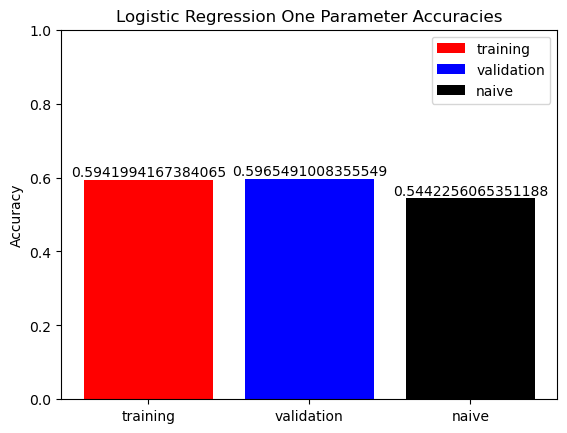

In [203]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [dist_log_train, dist_log_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

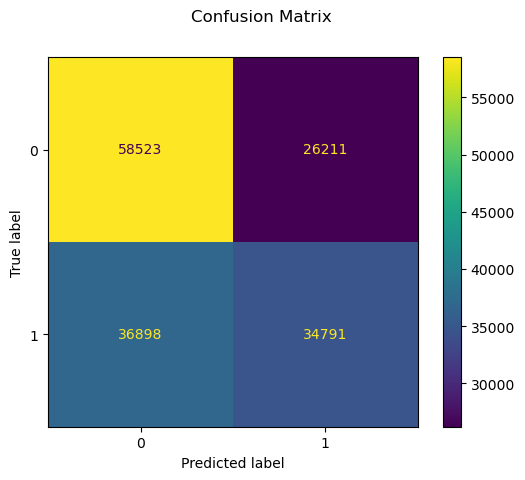

In [147]:
from sklearn import metrics
# Confusion matrix 
dist_log_pred = dist_log.predict(dist_Xval)
confusion_dist_log = metrics.ConfusionMatrixDisplay.from_predictions(dist_Yval, dist_log_pred, 
                                                                     values_format = '')
confusion_dist_log.figure_.suptitle("Confusion Matrix")
plt.show()

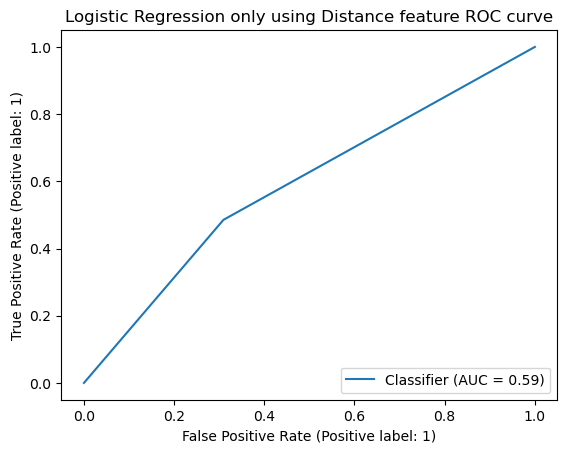

In [148]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay

# Logistic Regression
RocCurveDisplay.from_predictions(dist_Yval, dist_log_pred)
plt.title('Logistic Regression only using Distance feature ROC curve')
plt.show()

## Logistic Regression using all features

In [149]:
Xtrain = np.array(data_4.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(data_4['SHOT_MADE'])

Xtrain = scalar.fit_transform(Xtrain)

Xval = np.array(data_5.drop(columns = ['SHOT_MADE']))
Yval = np.array(data_5['SHOT_MADE'])

Xval = scalar.fit_transform(Xval)

In [150]:
log = LogisticRegression(random_state = 1)

log_search = RandomizedSearchCV(log, log_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
log_search.fit(Xtrain, Ytrain)
print(log_search.best_params_)
print(log_search.best_score_)

{'solver': 'saga', 'max_iter': 10000, 'C': 0.001}
0.6415343502600335


In [152]:
# penaltyterm = dist_log_search.best_params_['penalty']
cterm = dist_log_search.best_params_['C']
iterterm = dist_log_search.best_params_['max_iter']
solverterm = dist_log_search.best_params_['solver']



log = LogisticRegression(penalty = 'l1', C = cterm, max_iter = iterterm, solver = solverterm,
                             random_state = 1)

log.fit(Xtrain, Ytrain)
log_train = log.score(Xtrain, Ytrain)
log_val = log.score(Xval, Yval)

print(f'The training accuracy is {log_train}')
print(f'The validation accuracy is {log_val}')

The training accuracy is 0.6417479162078653
The validation accuracy is 0.635629031536283


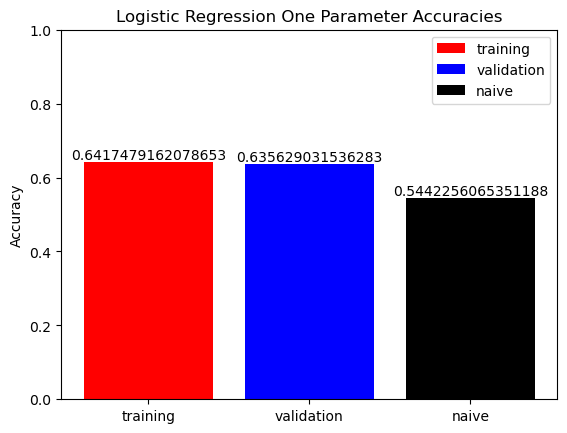

In [153]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [log_train, log_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

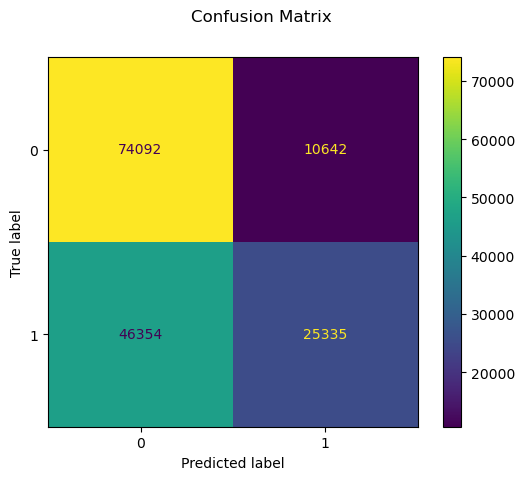

In [154]:
from sklearn import metrics
# Confusion matrix 
log_pred = log.predict(Xval)
confusion_log = metrics.ConfusionMatrixDisplay.from_predictions(Yval, log_pred, 
                                                                     values_format = '')
confusion_log.figure_.suptitle("Confusion Matrix")
plt.show()

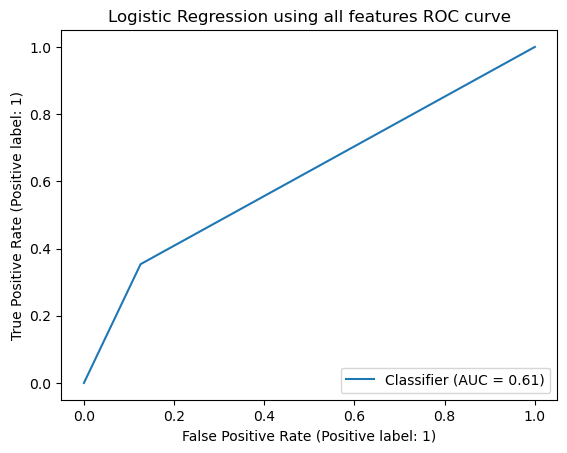

In [155]:
# Logistic Regression
RocCurveDisplay.from_predictions(Yval, log_pred)
plt.title('Logistic Regression using all features ROC curve')
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2005
#### VALIDATION FROM 2006-2007

In [160]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2005)]
val_data = shot_data[(shot_data['Season'] >= 2006) & (shot_data['Season'] <= 2007)]

In [161]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xtrain = scalar.fit_transform(Xtrain)

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

Xval = scalar.fit_transform(Xval)

In [162]:
log = LogisticRegression(random_state = 1)

log_search = RandomizedSearchCV(log, log_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
log_search.fit(Xtrain, Ytrain)
print(log_search.best_params_)
print(log_search.best_score_)

{'solver': 'saga', 'max_iter': 10000, 'C': 0.001}
0.6383974924086591


In [163]:
# penaltyterm = dist_log_search.best_params_['penalty']
cterm = dist_log_search.best_params_['C']
iterterm = dist_log_search.best_params_['max_iter']
solverterm = dist_log_search.best_params_['solver']



log = LogisticRegression(penalty = 'l1', C = cterm, max_iter = iterterm, solver = solverterm,
                             random_state = 1)

log.fit(Xtrain, Ytrain)
log_train = log.score(Xtrain, Ytrain)
log_val = log.score(Xval, Yval)

print(f'The training accuracy is {log_train}')
print(f'The validation accuracy is {log_val}')

The training accuracy is 0.6386913507689294
The validation accuracy is 0.6441024676789813


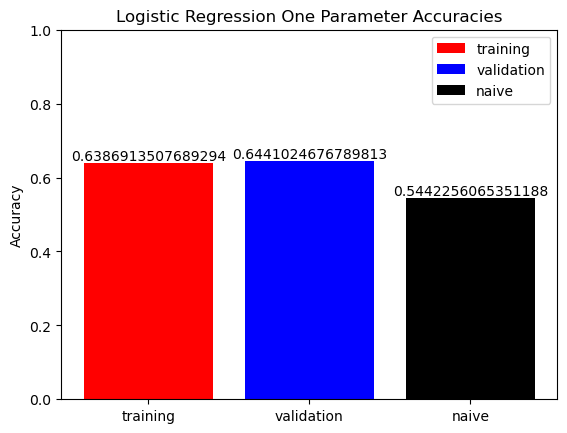

In [164]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [log_train, log_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

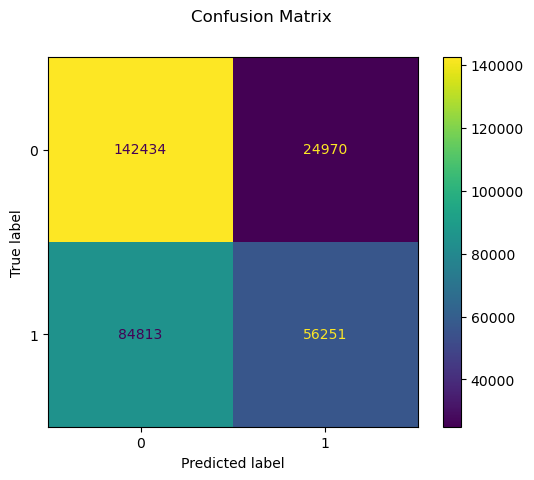

In [165]:
# Confusion matrix 
log_pred = log.predict(Xval)
confusion_log = metrics.ConfusionMatrixDisplay.from_predictions(Yval, log_pred, 
                                                                     values_format = '')
confusion_log.figure_.suptitle("Confusion Matrix")
plt.show()

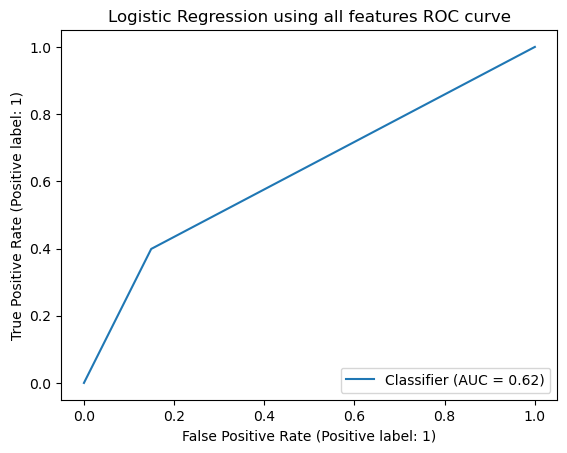

In [166]:
# Logistic Regression
RocCurveDisplay.from_predictions(Yval, log_pred)
plt.title('Logistic Regression using all features ROC curve')
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2007
#### VALIDATION FROM 2008-2011

In [167]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2007)]
val_data = shot_data[(shot_data['Season'] >= 2008) & (shot_data['Season'] <= 2011)]

In [168]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xtrain = scalar.fit_transform(Xtrain)

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

Xval = scalar.fit_transform(Xval)

In [169]:
log_search = RandomizedSearchCV(log, log_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
log_search.fit(Xtrain, Ytrain)
print(log_search.best_params_)
print(log_search.best_score_)

{'solver': 'saga', 'max_iter': 10000, 'C': 0.001}
0.6410926188592312


In [170]:
# penaltyterm = dist_log_search.best_params_['penalty']
cterm = dist_log_search.best_params_['C']
iterterm = dist_log_search.best_params_['max_iter']
solverterm = dist_log_search.best_params_['solver']



log = LogisticRegression(penalty = 'l1', C = cterm, max_iter = iterterm, solver = solverterm,
                             random_state = 1)

log.fit(Xtrain, Ytrain)
log_train = log.score(Xtrain, Ytrain)
log_val = log.score(Xval, Yval)

print(f'The training accuracy is {log_train}')
print(f'The validation accuracy is {log_val}')

The training accuracy is 0.6416229352992657
The validation accuracy is 0.6388830110934504


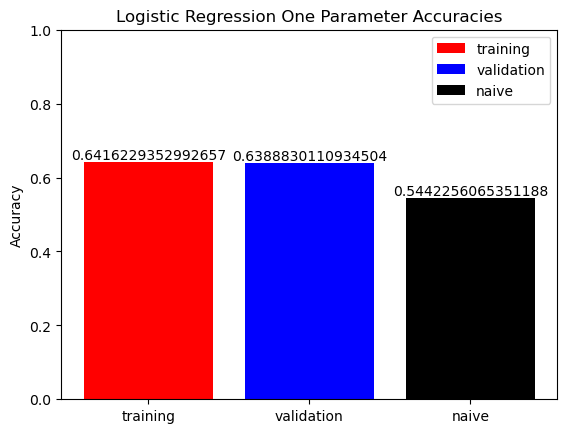

In [171]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [log_train, log_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

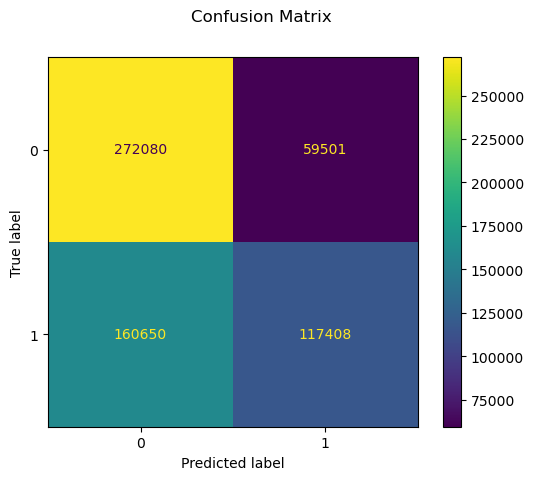

In [172]:
# Confusion matrix 
log_pred = log.predict(Xval)
confusion_log = metrics.ConfusionMatrixDisplay.from_predictions(Yval, log_pred, 
                                                                     values_format = '')
confusion_log.figure_.suptitle("Confusion Matrix")
plt.show()

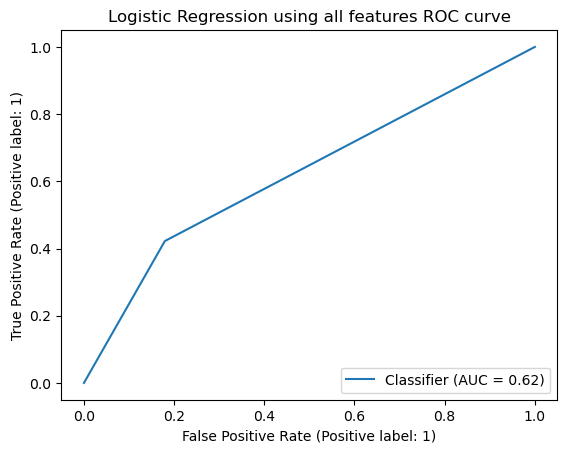

In [173]:
# Logistic Regression
RocCurveDisplay.from_predictions(Yval, log_pred)
plt.title('Logistic Regression using all features ROC curve')
plt.show()

It seems that the model consistantly uses the parameters {'solver': 'saga', 'max_iter': 10000, 'C': 0.001} so we will use this for the final testing

## Final Testing and Results

In [180]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2017)]
test_data = shot_data[(shot_data['Season'] >= 2018)]

In [181]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xtrain = scalar.fit_transform(Xtrain)

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

Xval = scalar.fit_transform(Xval)

In [182]:
log = LogisticRegression(penalty = 'l1', C = 0.001, max_iter = 10000, solver = 'saga',
                             random_state = 1)

log.fit(Xtrain, Ytrain)
log_train = log.score(Xtrain, Ytrain)
log_val = log.score(Xval, Yval)

print(f'The training accuracy is {log_train}')
print(f'The validation accuracy is {log_val}')

The training accuracy is 0.6357966042401282
The validation accuracy is 0.6400181090776673


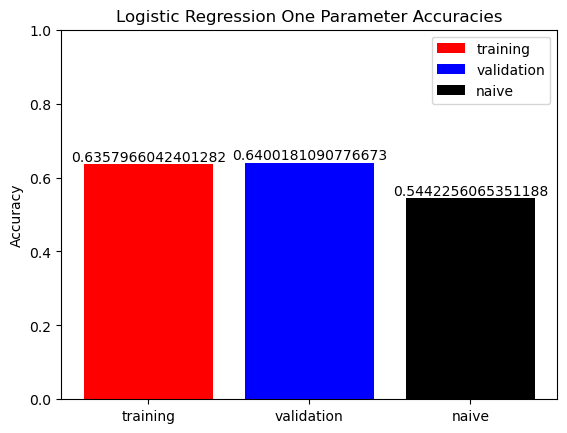

In [183]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [log_train, log_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

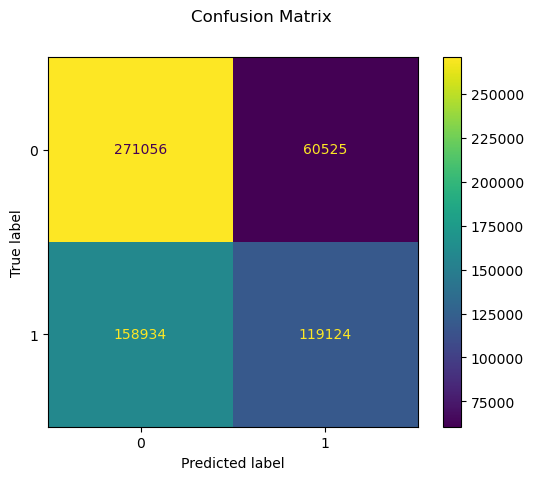

In [184]:
# Confusion matrix 
log_pred = log.predict(Xval)
confusion_log = metrics.ConfusionMatrixDisplay.from_predictions(Yval, log_pred, 
                                                                     values_format = '')
confusion_log.figure_.suptitle("Confusion Matrix")
plt.show()

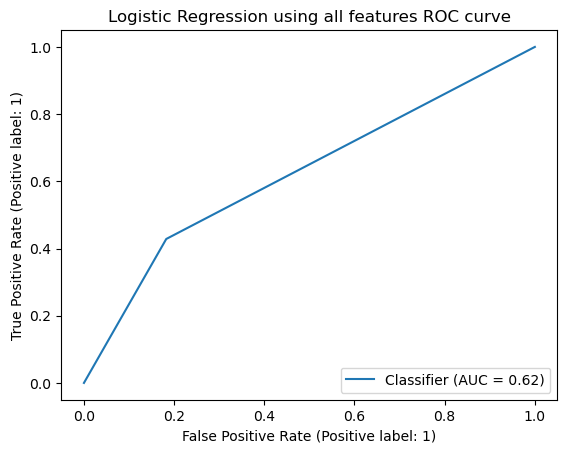

In [185]:
# Logistic Regression
RocCurveDisplay.from_predictions(Yval, log_pred)
plt.title('Logistic Regression using all features ROC curve')
plt.show()

In [197]:
feature_coef = pd.DataFrame(log.coef_.reshape(-1,1), index = shot_data.drop(columns = ['SHOT_MADE']).columns, 
                            columns = ['Coef_Val'])

In [199]:
feature_coef = feature_coef.sort_values(by = ['Coef_Val'], key = abs, ascending = False)

In [200]:
print(feature_coef)

                             Coef_Val
Driving Hook Shot           -0.451315
Running Tip Shot             0.272460
Turnaround Jump Shot         0.233817
Jump Shot                    0.168825
Driving Layup Shot           0.163329
...                               ...
Turnaround Finger Roll Shot -0.000442
3P%                          0.000000
Reverse Layup Shot           0.000000
Hook Shot                    0.000000
Driving Slam Dunk Shot       0.000000

[83 rows x 1 columns]


In [201]:
print(feature_coef.head(20))

                                Coef_Val
Driving Hook Shot              -0.451315
Running Tip Shot                0.272460
Turnaround Jump Shot            0.233817
Jump Shot                       0.168825
Driving Layup Shot              0.163329
Driving Reverse Dunk Shot       0.159052
Driving Reverse Layup Shot      0.154614
Floating Jump shot              0.124100
SHOT_DISTANCE                   0.117378
Putback Layup Shot              0.106189
Alley Oop Layup shot            0.099091
Season                         -0.098748
Putback Dunk Shot              -0.092683
Hook Bank Shot                  0.087157
Driving Finger Roll Layup Shot  0.084696
Running Reverse Layup Shot      0.080555
LOC_Y                          -0.079188
No Shot                         0.066662
FG%                             0.064013
Tip Shot                        0.063041


In [204]:
top_20 = feature_coef.head(20)

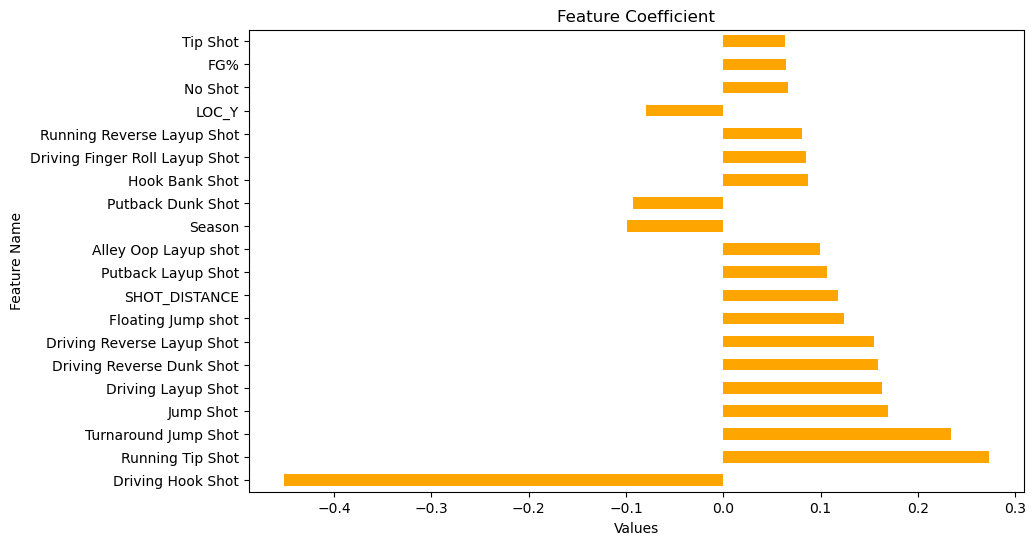

In [209]:
top_20['Coef_Val'].plot(kind='barh', figsize=(10, 6), color = 'orange')

plt.xlabel('Values')
plt.ylabel('Feature Name')
plt.title('Feature Coefficient')
plt.show()